## Evaluating the Parameter server from scratch

This notebook has the goal of evaluating the performance of the parameter server from scratch implementation. It will be compared to the built-in parameter server implementation from the `torch.nn.parallel` module.

### Parameter Server from scratch

Parmeter server is a technique for data parallel training of deep learning models. We have two types of nodes: server node and worker nodes. In our case, node == GPU == process.

**One cycle of updates**: Server sends the current parameters of the model to all the workers. Workers perform several backpropagation cycles and accumulate the gradients (without performing a gradient descent step). All the workers then send the gradients to the server, which averages them and updates the model parameters. The server then sends the updated parameters to all the workers. The updates happend synchronously.

All the synchronizations are computed after one epoch, for simplicity. For training, a dataset of 1000 MNIST examples is used, to keep the training task relatively simple.

Let's start with importing necessary packages.

In [7]:
import os
import time
import numpy as np
import pandas as pd
import os

Let's first plot the training accuracy and loss with respect to the number of epochs. This will give us an idea if the model is learning. 

In [8]:
logs_path = 'logs'
acc_path = os.path.join(logs_path, 'my_param_server_acc.csv')
loss_path = os.path.join(logs_path, 'my_param_server_loss.csv')

In [9]:
acc_df = pd.read_csv(acc_path)[['devout-grass-22 - training acc']].rename(columns={'devout-grass-22 - training acc': 'acc'})
loss_df = pd.read_csv(loss_path)[['devout-grass-22 - training loss']].rename(columns={'devout-grass-22 - training loss': 'loss'})
df = pd.concat([acc_df, loss_df], axis=1)

Text(0.5, 0.98, 'Training of from-scratch implementation of Parameter Server')

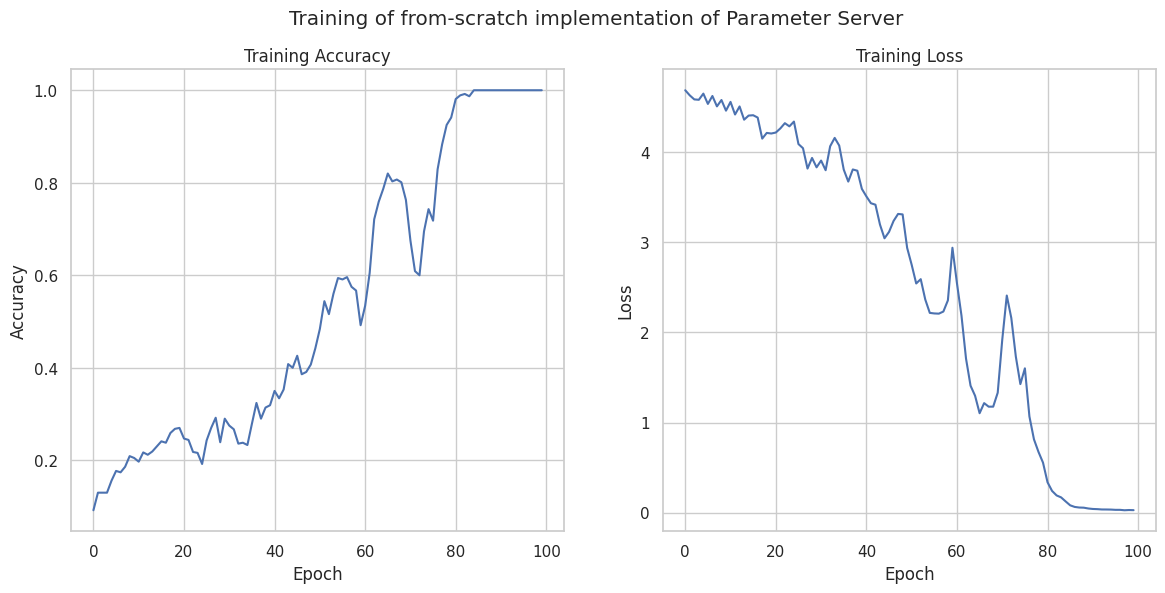

In [10]:
# scatter the training accuracy and training time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x=df.index, y='acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=df, x=df.index, y='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# subtitle
plt.suptitle('Training of from-scratch implementation of Parameter Server')


We can see that the model is able to overfit to the training data (that is a great sign, despite the name :D ) 

Let's compare to the builtin implementation of the parameter server.

In [11]:
builtin_loss_path = os.path.join(logs_path, 'builtin_param_loss.csv')
builtin_acc_path = os.path.join(logs_path, 'builtin_param_acc.csv')

builtin_loss_df = pd.read_csv(builtin_loss_path)[['lunar-spaceship-8 - train_loss']].rename(columns={'lunar-spaceship-8 - train_loss': 'loss'})
builtin_acc_df = pd.read_csv(builtin_acc_path)[['lunar-spaceship-8 - train_acc']].rename(columns={'lunar-spaceship-8 - train_acc': 'acc'})

builtin_acc_df['acc'] = builtin_acc_df['acc'] / builtin_acc_df['acc'].max()

builtin_df = pd.concat([builtin_acc_df, builtin_loss_df], axis=1)

Text(0.5, 0.98, 'Training of Builtin Parameter Server')

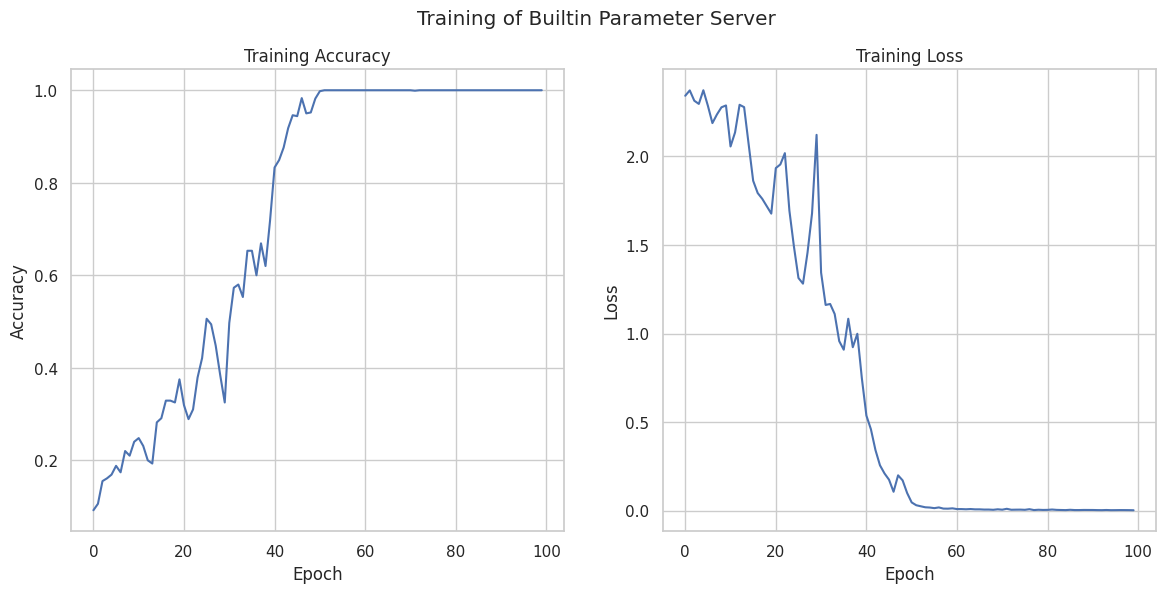

In [12]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=builtin_df, x=builtin_df.index, y='acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=builtin_df, x=builtin_df.index, y='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# subtitle
plt.suptitle('Training of Builtin Parameter Server')



We can see that the builtin method achieves the 100% accuracy in 40 epochs, while the from scratch implementation needes 80 epochs (2x more). Let's compare the time - performance plot, for more accurate comparison.

In [13]:
time_path = os.path.join(logs_path, 'my_param_server_time.csv')
time_df = pd.read_csv(time_path)[['devout-grass-22 - Time']].rename(columns={'devout-grass-22 - Time': 'time'})

In [14]:
builtin_time_path = os.path.join(logs_path, 'builtin_param_time.csv')
builtin_time_df = pd.read_csv(builtin_time_path)[['lunar-spaceship-8 - time']].rename(columns={'lunar-spaceship-8 - time': 'time'})

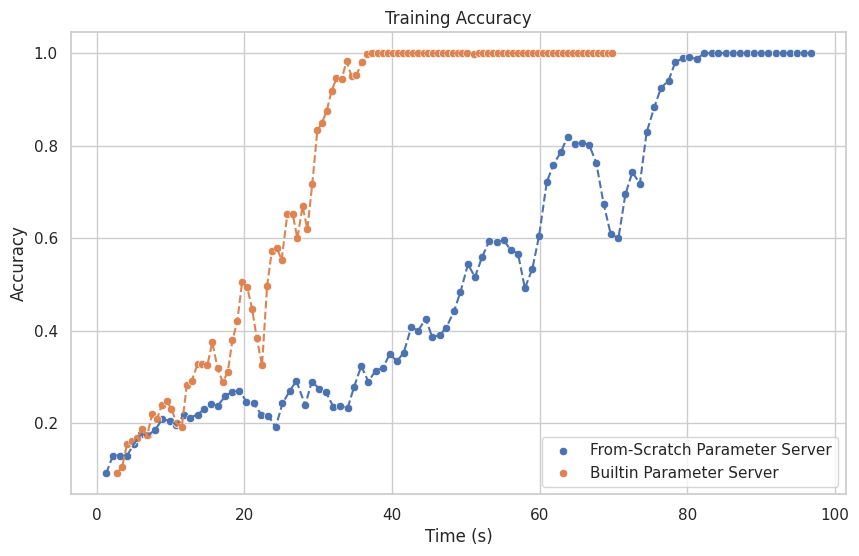

In [15]:
time_acc_df = pd.concat([time_df, acc_df], axis=1)
builtin_time_acc_df = pd.concat([builtin_time_df, builtin_acc_df], axis=1)

plt.figure(figsize=(10, 6))

sns.scatterplot(data=time_acc_df, x='time', y='acc', label='From-Scratch Parameter Server')
# dash line to connect the scattered points
plt.plot(time_acc_df['time'], time_acc_df['acc'], linestyle='dashed')

sns.scatterplot(data=builtin_time_acc_df, x='time', y='acc', label='Builtin Parameter Server')
plt.plot(builtin_time_acc_df['time'], builtin_time_acc_df['acc'], linestyle='dashed')


plt.title('Training Accuracy')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.legend()




We can see that the builtin method achieves the 100% accuracy around 2x faster than the from scratch implementation. Let's try to see what is the bottleneck.

### Breakdown of the time spent during the training

Let's try to see where does the most time go - is it calculation of gradients, sharing of the model to workers or is it the synchronization time

1. epoch calculation time - Time spend doing forward and backward pass on the model and actually updating the model parameters. In the single GPU training, this is almost all the time (except for overhead for logging and etc.)

2. model send time - Time spend sending the model weights to the workers. This shouldn't be a bottleneck, as the model is relatively small.

3. sync wait time - Time spent on waiting for all the workers to finish the epoch and send back gradients. This is a common source of inefficiencies in multi-GPU training and we want to minimize it.

In [29]:
epoch_calc_df = pd.read_csv(os.path.join(logs_path, 'my_param_epoch_calc.csv'))
model_send_df = pd.read_csv(os.path.join(logs_path, 'my_param_model_send.csv'))
total_epoch_time = 126.1 # in seconds
num_epochs = 100
avg_epoch_time = total_epoch_time / num_epochs

epoch_calc_df.rename(columns={'time': 'epoch_calc_time'}, inplace=True)
model_send_df.rename(columns={'time': 'model_send_time'}, inplace=True)
epoch_df = pd.concat([epoch_calc_df, model_send_df], axis=1)
epoch_df['total_epoch_time'] = avg_epoch_time
epoch_df['sync_time'] = epoch_df['total_epoch_time'] - epoch_df['epoch_calc_time'] - epoch_df['model_send_time']

Let's turn these into percentages

In [38]:
# turn the time into percentage
epoch_df['epoch_calc_time'] = epoch_df['epoch_calc_time'] / epoch_df['total_epoch_time'] * 100
epoch_df['model_send_time'] = epoch_df['model_send_time'] / epoch_df['total_epoch_time'] * 100
epoch_df['sync_time'] = epoch_df['sync_time'] / epoch_df['total_epoch_time'] * 100

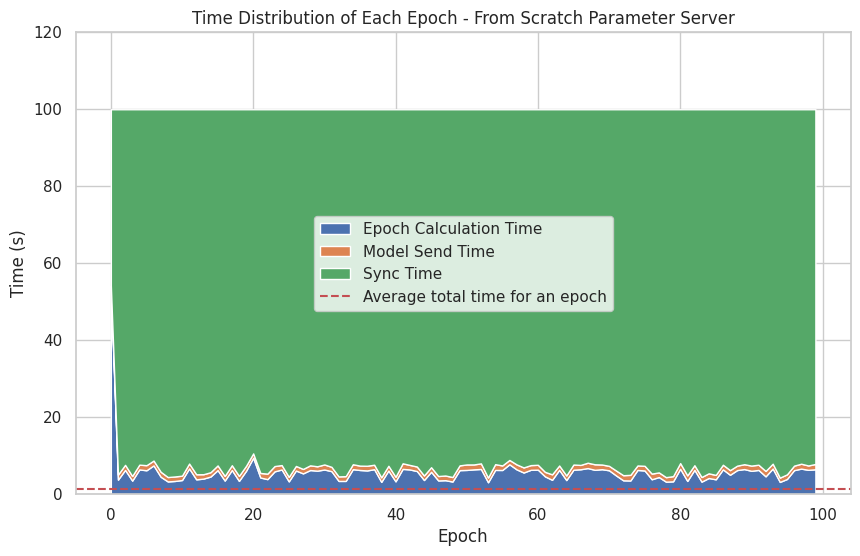

In [40]:
# stack plot of epoch_calc_time, model_send_time, and sync_time
plt.figure(figsize=(10, 6))
plt.stackplot(epoch_df.index, epoch_df['epoch_calc_time'], epoch_df['model_send_time'], epoch_df['sync_time'], labels=['Epoch Calculation Time', 'Model Send Time', 'Sync Time'])
plt.title('Time Distribution of Each Epoch - From Scratch Parameter Server')
plt.xlabel('Epoch')
# horizontal line to indicate the average epoch time
plt.axhline(y=avg_epoch_time, color='r', linestyle='dashed', label='Average total time for an epoch')
plt.ylabel('Time (s)')
plt.ylim(0, 120)
plt.legend()



We can see that the synchronization takes more than 90% of our time. This indicates that probably we are synchronizing our weights to often. If we consider the fact that our dataset has 1000 samples and that the batch_size is 512, that means that we are synchronizing our weights after every 2 batches, which is probably too often.

Let's see what happens when we train on 10k samples (instead of 1k).

In [65]:
df_epoch_calc = pd.read_csv(os.path.join(logs_path, 'epoch_calc_10k.csv'))
df_model_send = pd.read_csv(os.path.join(logs_path, 'model_send_10k.csv'))
df_sync_wait = pd.read_csv(os.path.join(logs_path, 'sync_wait_10k.csv'))

df_total = pd.concat([df_epoch_calc, df_model_send, df_sync_wait], axis=1)
df_total['total_time'] = df_total['epoch_calc_time'] + df_total['model_send_time'] + df_total['sync_time']
# turn the time into percentage
df_epoch_calc['epoch_calc_time'] = df_epoch_calc['epoch_calc_time'] / df_total['total_time'] * 100
df_model_send['model_send_time'] = df_model_send['model_send_time'] / df_total['total_time'] * 100
df_sync_wait['sync_time'] = df_sync_wait['sync_time'] / df_total['total_time'] * 100

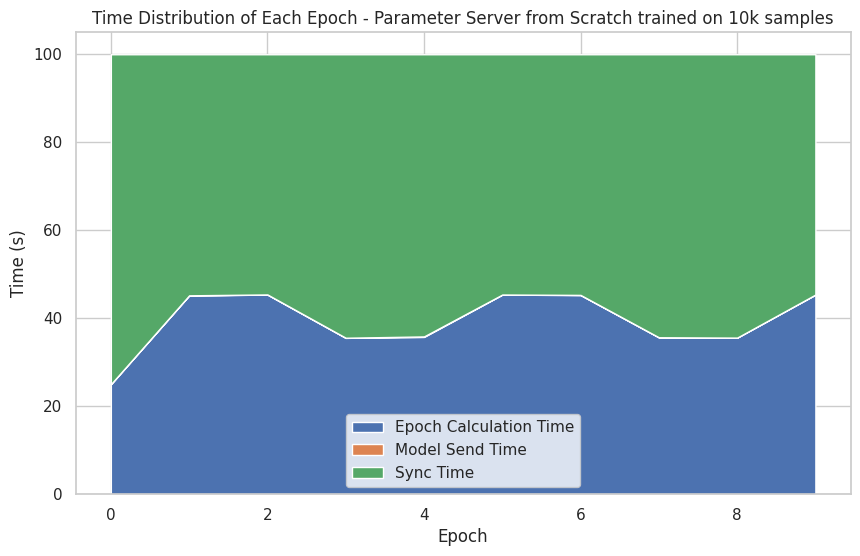

In [66]:
# stack plot 
plt.figure(figsize=(10, 6))
plt.stackplot(df_epoch_calc.index, df_epoch_calc['epoch_calc_time'], df_model_send['model_send_time'], df_sync_wait['sync_time'], labels=['Epoch Calculation Time', 'Model Send Time', 'Sync Time'])
plt.title('Time Distribution of Each Epoch - Parameter Server from Scratch trained on 10k samples')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.legend()



We can see that the model calculation time now takes a much larger percentage of the total time. This is desirable, as we want to maximize the time spent actually improving the model.

Of course, everything is a trade-off. When we make the synchronization less frequent, we are risking that the model training will diverge.

Therefore, the biggest value of torch.nn.DataParallel is actually efficiently implementing the synchronization of the model weights. This is where the boost in performance comes, when compared to the from scratch implementation.